In [1]:
from qiskit import QuantumCircuit, Aer, transpile
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
import argparse
import json

folder = os.getcwd()
while not folder.endswith("AutomatedPERTools"):
    folder = os.path.dirname(folder)
sys.path.append(os.path.join(folder, "pauli_lindblad_per"))

from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")

In [2]:
match 1:
    case 0:
        jsonfiles = [
            'E:/OneDrive/Dokumente/Uni_kram/Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_False_16_100_100_1000_FakeCasablancaV2_[0,1,2,3]_and_transpile__arrays.json',
            'E:/OneDrive/Dokumente/Uni_kram/Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/True_False_16_100_100_1000_FakeCasablancaV2_[0,1,2,3]_and_transpile__arrays.json',
            'E:/OneDrive/Dokumente/Uni_kram/Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_True_16_100_100_1000_FakeCasablancaV2_[0,1,2,3]_and_transpile__arrays.json',]
    case 1:
        jsonfiles = [
            'E:/OneDrive/Dokumente/Uni_kram/Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_False_16_100_100_1000_FakeMelbourneV2_[0,1,2,3]_and_transpile__arrays.json',
            'E:/OneDrive/Dokumente/Uni_kram/Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/True_False_16_100_100_1000_FakeMelbourneV2_[0,1,2,3]_and_transpile__arrays.json',
            'E:/OneDrive/Dokumente/Uni_kram/Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_True_16_100_100_1000_FakeMelbourneV2_[0,1,2,3]_and_transpile__arrays.json',]
    case 2:
        jsonfiles = [
            'E:/OneDrive/Dokumente/Uni_kram/Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/True_False_64_1000_1000_1000_FakeMelbourneV2_[0,1,2,3]_and_transpile__arrays.json',
            'Pending',
            'Pending',]
namebase = os.path.basename(jsonfiles[0][:len(jsonfiles[0])-12])
recalculate_ideals = True

In [3]:
split_namebase = namebase.split("_")
#parser.add_argument('--plusone', '-p', help='Takes Neighboring qubits into account', default=False, action='store_true')
if split_namebase[0] == "True":
    tomography_connections = True
else:
    tomography_connections = False
#parser.add_argument('--sum', '-s', help='Same as -p and turns sumation on over neighboring qubits', default=False, action='store_true')
if split_namebase[1] == "True":
    sum_over_lambda = True
    tomography_connections = True
else:
    sum_over_lambda = False
#parser.add_argument('--pntsamples', type=int, help='How many samples in PNT? Default: 16', default=16)
pntsamples = int(split_namebase[2])
#parser.add_argument('--pntsinglesamples', type=int, help='How many single samples in PNT? Default: 100', default=100)
pntsinglesamples = int(split_namebase[3])
#parser.add_argument('--persamples', type=int, help='How many samples in PER? Default: 100', default=100)
persamples = int(split_namebase[4])
#parser.add_argument('--shots', type=int, help='How many shots? Default: 1000', default=1000)
shots = int(split_namebase[5])
#parser.add_argument('--backend', type=str, help='Which backend to use? Default: FakeVigoV2', default="FakeVigoV2")
import qiskit.providers.fake_provider as fake_provider
backend = fake_provider.FakeVigoV2()
if split_namebase[6] != "FakeVigoV2":
    method = getattr(fake_provider, split_namebase[6])
    backend = method()
#parser.add_argument('--setqubits', type=int, nargs='+', help='Which qubits to use?: Default: 0123 and transpile')
import ast
qubits= ast.literal_eval(split_namebase[7])
num_qubits = len(qubits)
#if split_namebase[7] == '[0,1,2,3]' and split_namebase[8] == 'and' and split_namebase[9] == 'transpile':

In [4]:
data = {}
with open(jsonfiles[0], 'r') as file:
    data = json.load(file)
results_errors = [[d1,d2] for d1, d2 in data["results_errors"]]
results_at_noise = [[d1,d2,d3,d4] for d1, d2, d3, d4 in data["results_at_noise"]]
results_at_noise_errors = [[d1,d2,d3,d4] for d1, d2, d3, d4 in data["results_at_noise_errors"]]
results = [d for d in data["results"]]
noisyresult = [d for d in data["noisyresult"]]
res = data["res"]

In [5]:
def trotterLayer(h,J,dt,n):
    n=2
    trotterLayer = QuantumCircuit(num_qubits)
    trotterLayer.rx(dt*4*h, qubits)
    trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [qubits[2*i+1] for i in range(n)])
    trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
    trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [qubits[2*i+2] for i in range(n-1)])
    trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .2
n = 2

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(num_qubits)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    transpiled = transpile(trotterCircuit, backend)
    return transpiled

circuits = [maketrotterCircuit(i) for i in range(1,15)]
used_qubits = set()
for circuit in circuits: 
    for c in circuit: #look at the commands
        for bit in c.qubits: #record which qubits they use
            used_qubits.add(bit.index) #and save those
qubits = used_qubits
#print("Qubits set to ", qubits)

C:\Users\fabri\AppData\Local\Temp\ipykernel_18552\1544054782.py:33: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  used_qubits.add(bit.index) #and save those


In [6]:
noise_strengths = [0,0.5,1,2]
expectations = []
for q in qubits:
    expect = "I"*(backend.num_qubits) #15
    expect = expect[:q] + 'Z' + expect[q+1:]
    expectations.append("".join(reversed(expect)))

In [7]:
if recalculate_ideals:
    noisyresult = []
    for circ in circuits:
        qc = circ.copy()
        qc.measure_all()
        count= backend.run(qc, shots=shots).result().get_counts()
        count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
        tot = 0
        for key in count.keys():
            num = sum([(-1)**bit for i, bit in enumerate(key) if len(key)-1-i in qubits])
            tot += num*count[key]
        noisyresult.append(tot/(shots*n*2))
    data["noisyresult"] = noisyresult

KeyboardInterrupt: 

In [ ]:
if recalculate_ideals:
    res = []
    for circ in circuits:
        qc = circ.copy()
        qc.measure_all()
        count= Aer.get_backend('qasm_simulator').run(qc, shots=shots).result().get_counts()
        count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
        tot = 0
        for key in count.keys():
            num = sum([(-1)**bit for i, bit in enumerate(key) if len(key)-1-i in qubits])
            tot += num*count[key]
        res.append(tot/(shots*n*2))
    data["res"] = res
    with open(namebase + '_arrays.json', 'w') as file:
        json.dump(data, file)

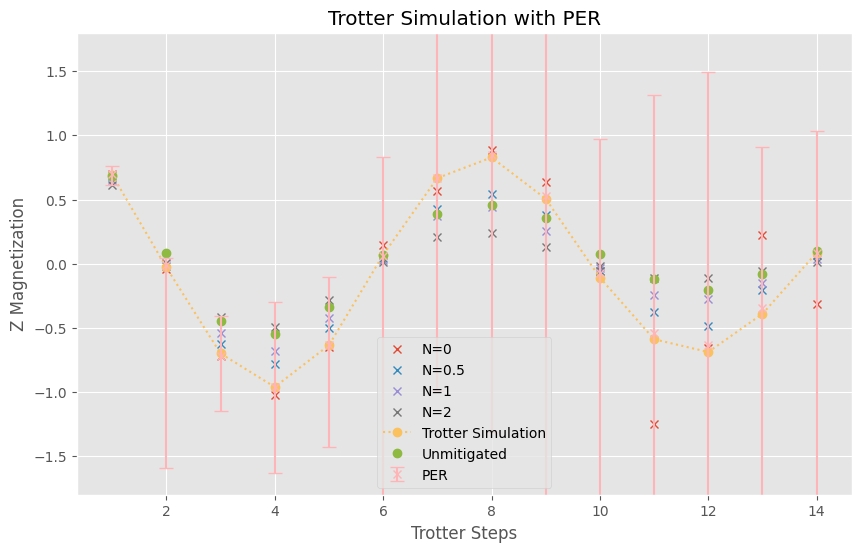

In [ ]:
plt.figure(figsize=(10,6))
for i, noise in enumerate(noise_strengths):
    plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.errorbar(range(1,15), results, yerr=[[np.abs(res[1]) for res in results_errors],[np.abs(res[0]) for res in results_errors]],fmt='x', capsize=5, label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
plt.savefig(namebase+"_Trotter_Sim_PER.png")

Text(0, 0.5, 'Z Magnetization')

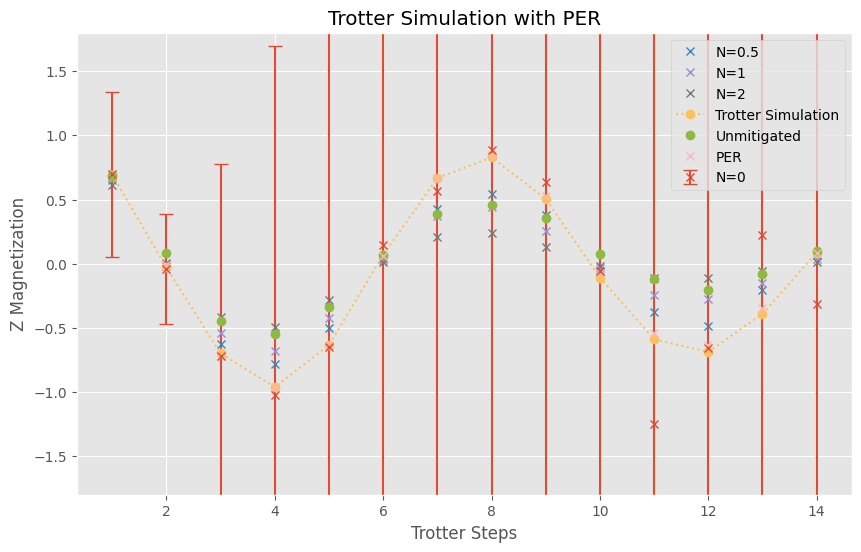

In [ ]:
plt.figure(figsize=(10,6))
for i, noise in enumerate(noise_strengths):
    if noise == 0:
        plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt='x', yerr=[res[i] for res in results_at_noise_errors], capsize=5, label='N='+str(noise))
    else:
        plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
        
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.plot(range(1,15), results, 'x', label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
#plt.savefig(namebase+"_Trotter_Sim_n_0.png")

Text(0, 0.5, 'Z Magnetization')

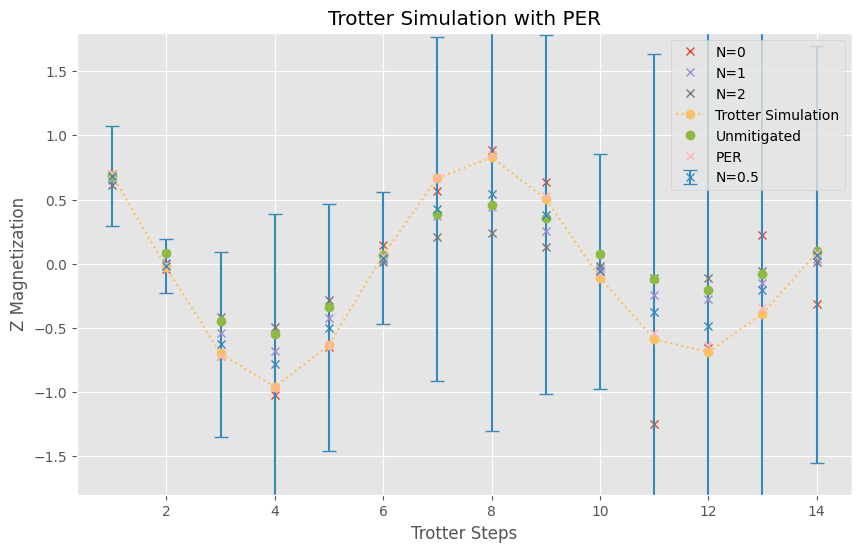

In [ ]:
plt.figure(figsize=(10,6))
for i, noise in enumerate(noise_strengths):
    if noise == 0.5:
        plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt='x', yerr=[res[i] for res in results_at_noise_errors], label='N='+str(noise), capsize=5)
    else:
        plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
        
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.plot(range(1,15), results, 'x', label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
#plt.savefig(namebase+"_Trotter_Sim_n_05.png")

In [ ]:
#for i in range (len(expectations)):
#    ax = circuit_results[0].get_result(expectations[i]).plot()
#    plt.title("Expectation vs Noise Strength " + expectations[i])
#    plt.xlabel("Noise Strength")
#    plt.ylabel("Expectation")
#    plt.savefig(namebase+"_Expectation_vs_Noise_Strength_" + expectations[i] + ".png")

In [ ]:
namebases = []
data = {}
for jfilename in jsonfiles:
    namebase = os.path.basename(jfilename)
    namebase = namebase[:len(namebase)-12]
    namebases.append(namebase)
    with open(jfilename, 'r') as file:
        data[namebase] = json.load(file) # names are: results, results_errors, results_at_noise, results_at_noise_errors, noisyresult, res
    data[namebase]["results_total_errors"] = [abs(a[0]) + abs(a[1]) for a in data[namebase]["results_errors"]]
    #data[namebase]["results_total_errors"] = data[namebase]["results"]

import matplotlib.pyplot as plt
import numpy as np

# Sample data
a = data[namebases[0]]["results_total_errors"]
b = data[namebases[1]]["results_total_errors"]
c = data[namebases[2]]["results_total_errors"]

# Number of bars
n = len(a)

# Positions of groups on the x-axis
ind = np.arange(n)

# Width of bars
width = 0.2

# Create a bar plot
fig, ax = plt.subplots(figsize=(15,6))
# Plotting the bars
bar1 = ax.bar(ind - width, a, width, label="Without extra qubits")#namebases[0])
bar2 = ax.bar(ind, b, width, label="With extra qubits")
bar3 = ax.bar(ind + width, c, width, label="With extra qubits an summation")

# Adding labels
ax.set_xlabel('Trotter Steps')
ax.set_ylabel('Expectation')
ax.set_title('Bar plot of the error values of the PER fits')
ax.set_xticks(ind)
ax.set_xticklabels([f'{i+1}' for i in range(n)])

# Add a legend
ax.legend()
namebase = ""
for i, name in enumerate(split_namebase):
    if i >= 3:
        namebase +=name+"_"
    
plt.savefig(namebase+"Error_Comparison.png")

FileNotFoundError: [Errno 2] No such file or directory: 'Pending'